In [3]:
pip install cvxopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 2.0 MB/s eta 0:00:0000:0100:010m
You should consider upgrading via the '/Users/apple/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from numpy import linalg
import sys
import cvxopt
import cvxopt.solvers

In [3]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [4]:
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

In [5]:
def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [16]:
class SVM(object):
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    def fit(self, x,y):
        n_samples, n_features = x.shape
        
        # Gram matrix
        k = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                k[i,j] = self.kernel(x[i], x[j])
                
        p = cvxopt.matrix(np.outer(y,y) * k)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
        
        # solve QP problem
        solution = cvxopt.solvers.qp(p, q, G, h, A, b)
        
        # Lagrange multipliers
        a = np.ravel(solution['x'])
        
        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a)) [sv]
        self.a = a [sv]
        self.sv = x[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))
        
        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * k[ind[n], sv])
        self.b /= len(self.a)
        
        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
                
        else:
            self.w = None
    
    def project(self, x):
        if self.w is not None:
            return np.dot(x, self.w) + self.b
        else:
            y_predict = np.zeros(len(x))
            for i in range(len(x)):
                s = 0 
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(x[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    def predict(self, x):
        return np.sign(self.project(x))

     pcost       dcost       gap    pres   dres
 0:  1.5015e+05 -7.3573e+07  2e+08  4e-01  5e-12
 1:  3.9209e+05 -9.8892e+06  2e+07  3e-02  8e-12
 2:  1.7780e+05 -1.9314e+06  2e+06  3e-03  3e-12
 3:  5.7067e+03 -2.8296e+05  3e+05  2e-04  3e-12
 4: -7.1052e+03 -3.3909e+04  3e+04  1e-05  3e-12
 5: -8.6107e+03 -3.3343e+04  2e+04  1e-05  3e-12
 6: -7.7543e+03 -3.1078e+04  2e+04  7e-06  3e-12
 7: -8.6317e+03 -2.9422e+04  2e+04  6e-06  3e-12
 8: -7.9386e+03 -2.8717e+04  2e+04  6e-06  3e-12
 9: -9.0885e+03 -2.2920e+04  1e+04  3e-06  3e-12
10: -9.4835e+03 -1.4596e+04  5e+03  9e-07  4e-12
11: -1.0010e+04 -1.4965e+04  5e+03  8e-07  4e-12
12: -1.0273e+04 -1.4277e+04  4e+03  5e-07  4e-12
13: -1.0496e+04 -1.2816e+04  2e+03  2e-07  4e-12
14: -1.0666e+04 -1.2806e+04  2e+03  2e-07  4e-12
15: -1.0900e+04 -1.2270e+04  1e+03  1e-07  5e-12
16: -1.0960e+04 -1.2022e+04  1e+03  2e-08  4e-12
17: -1.1053e+04 -1.1882e+04  8e+02  2e-08  5e-12
18: -1.0989e+04 -1.1816e+04  8e+02  2e-08  4e-12
19: -1.1060e+04 -1.17

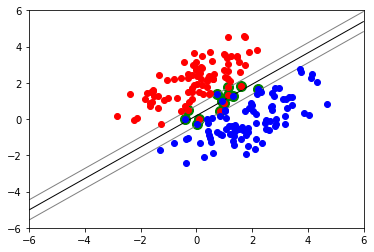

In [17]:
if __name__ == "__main__":
    import pylab as pl
    
    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        x1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(x1))
        x2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(x2)) * -1
        return x1,y1, x2, y2
    
    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0, 0.8], [0.8, 1.0]]
        x1 = np.random.multivariate_normal(mean1, cov, 50)
        x1 = np.vstack((x1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(x1))
        x2 = np.random.multivariate_normal(mean2, cov, 50)
        x2 = np.vstack((x2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(x2)) * -1
        return x1, y1, x2, y2
    
    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        x1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(x1))
        x2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(x2)) * -1
        return x1, y1, x2, y2
    
    def split_train(x1, y1, x2, y2):
        x1_train = x1[:90]
        y1_train = y1[:90]
        x2_train = x2[:90]
        y2_train = y2[:90]
        x_train = np.vstack((x1_train, x2_train))
        y_train = np.hstack((y1_train, y2_train))
        return x_train, y_train
    
    def split_test(x1, y1, x2, y2):
        x1_test = x1[:90]
        y1_test = y1[:90]
        x2_test = x2[:90]
        y2_test = y2[:90]
        x_test = np.vstack((x1_test, x2_test))
        y_test = np.hstack((y1_test, y2_test))
        return x_test, y_test
    
    def plot_margin(x1_train, x2_train, clf):
        def f(x, w, b, c=0):
            #given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]
        
        pl.plot(x1_train[:,0], x1_train[:,1], "ro")
        pl.plot(x2_train[:,0], x2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
        
        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")
        
        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")
        
        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")
        
        pl.axis("tight")
        pl.show()
    
    def plot_contour(x1_train, x2_train, clf):
        pl.plot(x1_train[:,0], x1_train[:,1], "ro")
        pl.plot(x2_train[:,0], x2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
        
        x1, x2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        x = np.array([[x1, x2] for x1, x2 in zip(np.ravel(x1), np.ravel(x2))])
        z = clf.project(x).reshape(x1.shape)
        pl.contour(x1, x2, z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(x1, x2, z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(x1, x2, z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
        
        pl.axis("tight")
        pl.show()
    
    def test_linear():
        x1,y1,x2,y2 = gen_lin_separable_data()
        x_train, y_train = split_train(x1, y1, x2, y2)
        x_test, y_test = split_test(x1, y1, x2, y2)
        
        clf = SVM()
        clf.fit(x_train, y_train)
        
        y_predict = clf.predict(x_test)
        correct = np.sum(y_predict == y_test)
        print("%d  out of %d predictions correct" % (correct, len(y_predict)))
        
        plot_margin(x_train[y_train==1], x_train[y_train==-1], clf)
        
    def test_non_linear():
        x1, y1, x2, y2 = gen_non_lin_separable_data()
        x_train, y_train = split_train(x1, y1, x2, y2)
        x_test, y_test = split_test(x1, y1, x2, y2)
        
        clf = SVM(polynomial_kernel)
        clf.fit(x_train, y_train)
        
        y_predict = clf.predict(x_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))
        
        plot_contour(x_train[y_train==1], x_train[y_train==-1], clf)
        
    def test_soft():
        x1, y1, x2, y2 = gen_lin_separable_overlap_data()
        x_train, y_train = split_train(x1, y1, x2, y2)
        x_test, y_test = split_test(x1, y1, x2, y2)
        
        clf = SVM(C=1000.1)
        clf.fit(x_train, y_train)
        
        y_predict = clf.predict(x_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))
        
        plot_contour(x_train[y_train==1], x_train[y_train==-1], clf)
    
    
    #test_linear()
    #test_non_linear()
    test_soft()
        

# SVM PARAMETERS-p.33

In [19]:
import numpy as np
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
df = pd.read_csv('breast-cancer-wisconsin.data.txt')
df.replace('?', -99999, inplace=True)
df.drop(['id'], 1, inplace=True)

x = np.array(df.drop(['class'], 1))
y = np.array(df['class'])

x_train, x_test, y_train, t_test = train_test_split(x,y,test_size=0.2)

clf = svm.SVC()
clf.fit(x_train, y_train)

accuracy = clf.score(x_test, y_test)